In [1]:
import os
from pathlib import Path
from tqdm.auto import tqdm
import albumentations as A
from tqdm.contrib.concurrent import thread_map
from multiprocessing.dummy import freeze_support
from multiprocessing import RLock

In [2]:
def list_dir_abs_path(path):
    path = Path(path)
    dirs = os.listdir(path)
    return list(map(lambda x: path/x, dirs))


In [3]:
val_samples = 1
train_samples = 1

batch_size = 1

In [4]:
resized_img_path = Path(f'F:/workspace/datasets/DeepFashion2 Dataset/train_256/image')
resized_msk_path = Path(str(resized_img_path.resolve()) + "_mask")

In [5]:
img_size = (256, 256)
num_classes = 13
epochs = 50

In [6]:
input_img_paths = sorted(list_dir_abs_path(resized_img_path))
target_img_paths = sorted(list_dir_abs_path(resized_msk_path))
assert len(input_img_paths) == len(target_img_paths)
len(input_img_paths)

191961

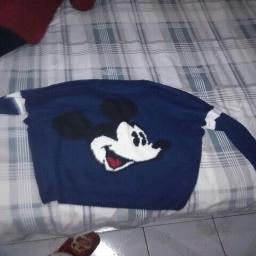

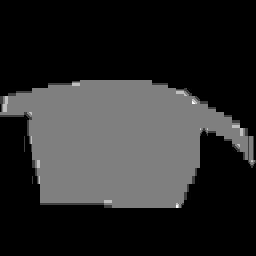

In [7]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [8]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
            
            
            
        return x, y


In [9]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
import random

# Split our img paths into a training and a validation set
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

train_input_img_paths = train_input_img_paths[-train_samples:]
train_target_img_paths = train_target_img_paths[-train_samples:]



val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [11]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 1_000
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 7.5276 - val_loss: 348.3722
Epoch 2/1000
1/1 [==============================] - 0s 485ms/step - loss: 2.9655 - val_loss: 350.7496
Epoch 3/1000
1/1 [==============================] - 0s 432ms/step - loss: 7.3547 - val_loss: 469.3359
Epoch 4/1000
1/1 [==============================] - 0s 498ms/step - loss: 0.9380 - val_loss: 348.0925
Epoch 5/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.7799 - val_loss: 321.6617
Epoch 6/1000
1/1 [==============================] - 0s 490ms/step - loss: 0.4086 - val_loss: 266.7383
Epoch 7/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.2804 - val_loss: 245.4007
Epoch 8/1000
1/1 [==============================] - 1s 500ms/step - loss: 0.2248 - val_loss: 203.4386
Epoch 9/1000
1/1 [==============================] - 0s 436ms/step - loss: 0.3034 - val_loss: 193.2600
Epoch 10/1000
1/1 [==============================] - 0s 477ms/step - loss: 0.3549 - v

1/1 [==============================] - 0s 477ms/step - loss: 0.0388 - val_loss: 3.0310
Epoch 82/1000
1/1 [==============================] - 0s 453ms/step - loss: 0.0504 - val_loss: 2.6801
Epoch 83/1000
1/1 [==============================] - 0s 471ms/step - loss: 0.0347 - val_loss: 2.7391
Epoch 84/1000
1/1 [==============================] - 0s 476ms/step - loss: 0.0407 - val_loss: 2.3405
Epoch 85/1000
1/1 [==============================] - 0s 454ms/step - loss: 0.0379 - val_loss: 2.5926
Epoch 86/1000
1/1 [==============================] - 0s 482ms/step - loss: 0.0499 - val_loss: 2.1617
Epoch 87/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.0715 - val_loss: 2.5605
Epoch 88/1000
1/1 [==============================] - 0s 489ms/step - loss: 0.1271 - val_loss: 2.3636
Epoch 89/1000
1/1 [==============================] - 0s 476ms/step - loss: 0.1726 - val_loss: 2.3518
Epoch 90/1000
1/1 [==============================] - 0s 453ms/step - loss: 0.0974 - val_loss: 2.1206
Epoc

1/1 [==============================] - 0s 459ms/step - loss: 0.1990 - val_loss: 1.9235
Epoch 162/1000
1/1 [==============================] - 0s 484ms/step - loss: 0.0436 - val_loss: 2.0361
Epoch 163/1000
1/1 [==============================] - 0s 457ms/step - loss: 0.0203 - val_loss: 1.9330
Epoch 164/1000
1/1 [==============================] - 0s 498ms/step - loss: 0.0149 - val_loss: 2.0006
Epoch 165/1000
1/1 [==============================] - 0s 451ms/step - loss: 0.0122 - val_loss: 1.9593
Epoch 166/1000
1/1 [==============================] - 0s 484ms/step - loss: 0.0107 - val_loss: 1.9993
Epoch 167/1000
1/1 [==============================] - 0s 463ms/step - loss: 0.0097 - val_loss: 1.9738
Epoch 168/1000
1/1 [==============================] - 1s 507ms/step - loss: 0.0090 - val_loss: 2.0043
Epoch 169/1000
1/1 [==============================] - 1s 512ms/step - loss: 0.0084 - val_loss: 1.9776
Epoch 170/1000
1/1 [==============================] - 1s 566ms/step - loss: 0.0079 - val_loss: 2.

1/1 [==============================] - 0s 480ms/step - loss: 0.0035 - val_loss: 2.7158
Epoch 242/1000
1/1 [==============================] - 0s 464ms/step - loss: 0.0033 - val_loss: 2.7173
Epoch 243/1000
1/1 [==============================] - 0s 476ms/step - loss: 0.0031 - val_loss: 2.7189
Epoch 244/1000
1/1 [==============================] - 0s 460ms/step - loss: 0.0029 - val_loss: 2.7203
Epoch 245/1000
1/1 [==============================] - 0s 476ms/step - loss: 0.0028 - val_loss: 2.7222
Epoch 246/1000
1/1 [==============================] - 0s 467ms/step - loss: 0.0026 - val_loss: 2.7232
Epoch 247/1000
1/1 [==============================] - 0s 474ms/step - loss: 0.0025 - val_loss: 2.7258
Epoch 248/1000
1/1 [==============================] - 0s 473ms/step - loss: 0.0024 - val_loss: 2.7273
Epoch 249/1000
1/1 [==============================] - 0s 470ms/step - loss: 0.0022 - val_loss: 2.7305
Epoch 250/1000
1/1 [==============================] - 0s 466ms/step - loss: 0.0021 - val_loss: 2.

1/1 [==============================] - 1s 505ms/step - loss: 3.8095e-04 - val_loss: 2.1980
Epoch 321/1000
1/1 [==============================] - 0s 496ms/step - loss: 3.6070e-04 - val_loss: 2.2051
Epoch 322/1000
1/1 [==============================] - 0s 464ms/step - loss: 3.4154e-04 - val_loss: 2.2120
Epoch 323/1000
1/1 [==============================] - 0s 477ms/step - loss: 3.2347e-04 - val_loss: 2.2191
Epoch 324/1000
1/1 [==============================] - 0s 499ms/step - loss: 3.0648e-04 - val_loss: 2.2263
Epoch 325/1000
1/1 [==============================] - 0s 499ms/step - loss: 2.9046e-04 - val_loss: 2.2337
Epoch 326/1000
1/1 [==============================] - 1s 501ms/step - loss: 2.7538e-04 - val_loss: 2.2418
Epoch 327/1000
1/1 [==============================] - 1s 501ms/step - loss: 2.6111e-04 - val_loss: 2.2492
Epoch 328/1000
1/1 [==============================] - 0s 493ms/step - loss: 2.4775e-04 - val_loss: 2.2574
Epoch 329/1000
1/1 [==============================] - 1s 500m

1/1 [==============================] - 0s 485ms/step - loss: 1.4454e-04 - val_loss: 2.6362
Epoch 399/1000
1/1 [==============================] - 0s 483ms/step - loss: 1.5472e-04 - val_loss: 2.6118
Epoch 400/1000
1/1 [==============================] - 0s 474ms/step - loss: 2.1567e-04 - val_loss: 2.6982
Epoch 401/1000
1/1 [==============================] - 0s 470ms/step - loss: 4.3155e-04 - val_loss: 2.5511
Epoch 402/1000
1/1 [==============================] - 0s 491ms/step - loss: 0.0035 - val_loss: 3.0151
Epoch 403/1000
1/1 [==============================] - 0s 466ms/step - loss: 0.0245 - val_loss: 1.1479
Epoch 404/1000
1/1 [==============================] - 0s 486ms/step - loss: 0.1955 - val_loss: 2.4184
Epoch 405/1000
1/1 [==============================] - 0s 486ms/step - loss: 0.0605 - val_loss: 2.5635
Epoch 406/1000
1/1 [==============================] - 0s 482ms/step - loss: 0.1607 - val_loss: 2.3063
Epoch 407/1000
1/1 [==============================] - 0s 457ms/step - loss: 0.119

Epoch 476/1000
1/1 [==============================] - 0s 465ms/step - loss: 0.0105 - val_loss: 1.4457
Epoch 477/1000
1/1 [==============================] - 1s 513ms/step - loss: 0.0972 - val_loss: 1.8452
Epoch 478/1000
1/1 [==============================] - 0s 475ms/step - loss: 0.0753 - val_loss: 2.1121
Epoch 479/1000
1/1 [==============================] - 0s 497ms/step - loss: 0.5162 - val_loss: 4.7727
Epoch 480/1000
1/1 [==============================] - 0s 484ms/step - loss: 0.0602 - val_loss: 3.3625
Epoch 481/1000
1/1 [==============================] - 1s 521ms/step - loss: 0.0193 - val_loss: 3.7882
Epoch 482/1000
1/1 [==============================] - 0s 477ms/step - loss: 0.0033 - val_loss: 3.7397
Epoch 483/1000
1/1 [==============================] - 1s 522ms/step - loss: 0.0015 - val_loss: 3.7199
Epoch 484/1000
1/1 [==============================] - 0s 489ms/step - loss: 0.0012 - val_loss: 3.7080
Epoch 485/1000
1/1 [==============================] - 0s 496ms/step - loss: 0.0010

1/1 [==============================] - 0s 486ms/step - loss: 2.7792e-05 - val_loss: 3.6736
Epoch 554/1000
1/1 [==============================] - 1s 510ms/step - loss: 6.8121e-05 - val_loss: 3.6543
Epoch 555/1000
1/1 [==============================] - 0s 485ms/step - loss: 0.0049 - val_loss: 3.4381
Epoch 556/1000
1/1 [==============================] - 0s 495ms/step - loss: 0.0585 - val_loss: 4.6034
Epoch 557/1000
1/1 [==============================] - 1s 510ms/step - loss: 0.3903 - val_loss: 3.3399
Epoch 558/1000
1/1 [==============================] - 1s 501ms/step - loss: 0.6110 - val_loss: 4.0335
Epoch 559/1000
1/1 [==============================] - 0s 490ms/step - loss: 0.0740 - val_loss: 4.4481
Epoch 560/1000
1/1 [==============================] - 1s 506ms/step - loss: 0.0120 - val_loss: 3.8156
Epoch 561/1000
1/1 [==============================] - 0s 482ms/step - loss: 0.0040 - val_loss: 3.8340
Epoch 562/1000
1/1 [==============================] - 1s 505ms/step - loss: 0.0026 - val_

1/1 [==============================] - 1s 509ms/step - loss: 6.7413e-04 - val_loss: 3.5012
Epoch 631/1000
1/1 [==============================] - 1s 500ms/step - loss: 0.0538 - val_loss: 2.2240
Epoch 632/1000
1/1 [==============================] - 1s 500ms/step - loss: 0.3342 - val_loss: 2.1218
Epoch 633/1000
1/1 [==============================] - 1s 509ms/step - loss: 0.0371 - val_loss: 1.8797
Epoch 634/1000
1/1 [==============================] - 1s 525ms/step - loss: 0.0550 - val_loss: 2.1902
Epoch 635/1000
1/1 [==============================] - 1s 543ms/step - loss: 0.0502 - val_loss: 2.0845
Epoch 636/1000
1/1 [==============================] - 0s 464ms/step - loss: 0.0079 - val_loss: 2.0036
Epoch 637/1000
1/1 [==============================] - 0s 469ms/step - loss: 0.0011 - val_loss: 2.0744
Epoch 638/1000
1/1 [==============================] - 1s 518ms/step - loss: 6.7454e-04 - val_loss: 2.0981
Epoch 639/1000
1/1 [==============================] - 0s 496ms/step - loss: 5.5891e-04 - 

1/1 [==============================] - 0s 492ms/step - loss: 1.7505e-05 - val_loss: 2.7211
Epoch 708/1000
1/1 [==============================] - 0s 459ms/step - loss: 1.6725e-05 - val_loss: 2.7305
Epoch 709/1000
1/1 [==============================] - 0s 495ms/step - loss: 1.5981e-05 - val_loss: 2.7397
Epoch 710/1000
1/1 [==============================] - 0s 483ms/step - loss: 1.5271e-05 - val_loss: 2.7492
Epoch 711/1000
1/1 [==============================] - 0s 496ms/step - loss: 1.4589e-05 - val_loss: 2.7585
Epoch 712/1000
1/1 [==============================] - 0s 490ms/step - loss: 1.3939e-05 - val_loss: 2.7679
Epoch 713/1000
1/1 [==============================] - 0s 487ms/step - loss: 1.3318e-05 - val_loss: 2.7765
Epoch 714/1000
1/1 [==============================] - 1s 511ms/step - loss: 1.2721e-05 - val_loss: 2.7861
Epoch 715/1000
1/1 [==============================] - 0s 480ms/step - loss: 1.2148e-05 - val_loss: 2.7952
Epoch 716/1000
1/1 [==============================] - 0s 463m

Epoch 785/1000
1/1 [==============================] - 1s 513ms/step - loss: 7.3302e-05 - val_loss: 1.9073
Epoch 786/1000
1/1 [==============================] - 0s 470ms/step - loss: 6.9901e-05 - val_loss: 1.9218
Epoch 787/1000
1/1 [==============================] - 1s 523ms/step - loss: 6.6688e-05 - val_loss: 1.9365
Epoch 788/1000
1/1 [==============================] - 0s 470ms/step - loss: 6.3634e-05 - val_loss: 1.9507
Epoch 789/1000
1/1 [==============================] - 1s 525ms/step - loss: 6.0747e-05 - val_loss: 1.9651
Epoch 790/1000
1/1 [==============================] - 1s 525ms/step - loss: 5.8014e-05 - val_loss: 1.9794
Epoch 791/1000
1/1 [==============================] - 0s 497ms/step - loss: 5.5423e-05 - val_loss: 1.9937
Epoch 792/1000
1/1 [==============================] - 0s 468ms/step - loss: 5.2961e-05 - val_loss: 2.0080
Epoch 793/1000
1/1 [==============================] - 1s 518ms/step - loss: 5.0626e-05 - val_loss: 2.0223
Epoch 794/1000
1/1 [==========================

1/1 [==============================] - 1s 505ms/step - loss: 2.5660e-06 - val_loss: 3.0156
Epoch 863/1000
1/1 [==============================] - 0s 482ms/step - loss: 2.4555e-06 - val_loss: 3.0278
Epoch 864/1000
1/1 [==============================] - 0s 493ms/step - loss: 2.3501e-06 - val_loss: 3.0421
Epoch 865/1000
1/1 [==============================] - 1s 501ms/step - loss: 2.2493e-06 - val_loss: 3.0541
Epoch 866/1000
1/1 [==============================] - 0s 479ms/step - loss: 2.1529e-06 - val_loss: 3.0694
Epoch 867/1000
1/1 [==============================] - 0s 478ms/step - loss: 2.0605e-06 - val_loss: 3.0800
Epoch 868/1000
1/1 [==============================] - 0s 492ms/step - loss: 1.9728e-06 - val_loss: 3.0958
Epoch 869/1000
1/1 [==============================] - 0s 486ms/step - loss: 1.8887e-06 - val_loss: 3.1060
Epoch 870/1000
1/1 [==============================] - 0s 475ms/step - loss: 1.8086e-06 - val_loss: 3.1226
Epoch 871/1000
1/1 [==============================] - 0s 485m

Epoch 940/1000
1/1 [==============================] - 0s 465ms/step - loss: 2.5845e-05 - val_loss: 4.2027
Epoch 941/1000
1/1 [==============================] - 0s 490ms/step - loss: 2.4877e-05 - val_loss: 4.2155
Epoch 942/1000
1/1 [==============================] - 0s 469ms/step - loss: 2.3939e-05 - val_loss: 4.2281
Epoch 943/1000
1/1 [==============================] - 0s 472ms/step - loss: 2.3036e-05 - val_loss: 4.2408
Epoch 944/1000
1/1 [==============================] - 0s 459ms/step - loss: 2.2164e-05 - val_loss: 4.2531
Epoch 945/1000
1/1 [==============================] - 0s 490ms/step - loss: 2.1322e-05 - val_loss: 4.2655
Epoch 946/1000
1/1 [==============================] - 0s 460ms/step - loss: 2.0510e-05 - val_loss: 4.2778
Epoch 947/1000
1/1 [==============================] - 1s 503ms/step - loss: 1.9724e-05 - val_loss: 4.2900
Epoch 948/1000
1/1 [==============================] - 0s 491ms/step - loss: 1.8969e-05 - val_loss: 4.3021
Epoch 949/1000
1/1 [==========================

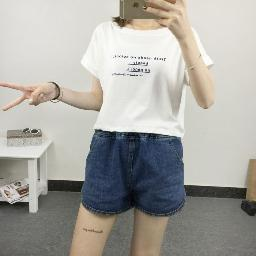

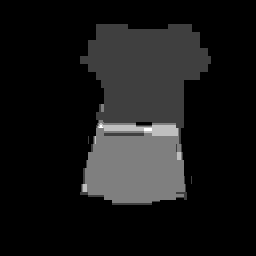

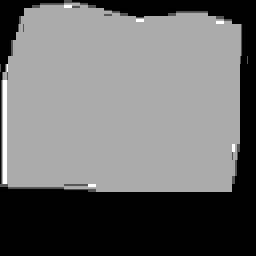

In [12]:
# Generate predictions for all images in the validation set

#val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
#val_preds = model.predict(val_gen)
val_preds = model.predict(train_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 0#min(10, val_samples - 1)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
#display_mask(i)  # Note that the model only sees inputs at 150x150.
display_mask(i)